# Brain Imaging Analysis for PTE Prediction

This notebook analyzes brain imaging data to predict Post-Traumatic Epilepsy (PTE) versus Traumatic Brain Injury (TBI) outcomes using:
1. Volume-adjusted measurements
2. Thickness-adjusted measurements  
3. Combined volume and thickness measurements

The goal is to optimize prediction sensitivity for PTE cases using cross-validation and appropriate class weighting.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, classification_report

In [4]:
# Load adjusted datasets
volume_adj = pd.read_csv('df_vol_adj.csv')
thickness_adj = pd.read_csv('df_thic_adj.csv')

# Quick look at data
print("Volume data shape:", volume_adj.shape)
print("Thickness data shape:", thickness_adj.shape)
print("\nVolume data columns:", volume_adj.columns.tolist()[:5], "...")
print("\nUnique outcomes:", volume_adj['outcome'].unique())

Volume data shape: (64, 76)
Thickness data shape: (64, 78)

Volume data columns: ['subject', 'site', 'age', 'sex', 'gcs'] ...

Unique outcomes: ['PTE' 'TBI']


## Helper Functions
Below are utility functions for model training and evaluation

In [5]:
def prepare_data(df):
    """Prepare data by removing unnecessary columns and standardizing features"""
    # Remove non-feature columns
    X = df.drop(columns=['outcome', 'sex', 'subject', 'pid', 'site'])
    y = df['outcome'].map({'PTE': 1, 'TBI': 0})
    
    # Add sex as dummy variable
    X = pd.concat([X, pd.get_dummies(df['sex'], drop_first=True)], axis=1)
    
    return X, y

def train_evaluate_model(X, y, class_weights, n_splits=5):
    """Train and evaluate model using k-fold cross validation"""
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    pte_sensitivities = []
    tbi_sensitivities = []
    
    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = RandomForestClassifier(
            class_weight=class_weights,
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            random_state=42
        )
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        pte_sens = recall_score(y_test, y_pred, pos_label=1)
        tbi_sens = recall_score(y_test, y_pred, pos_label=0)
        
        pte_sensitivities.append(pte_sens)
        tbi_sensitivities.append(tbi_sens)
    
    return np.mean(pte_sensitivities), np.mean(tbi_sensitivities)

## Model 1: Volume-Based Classification
Using volume-adjusted measurements to predict PTE vs TBI outcomes

In [7]:
# Prepare volume data
X_vol, y_vol = prepare_data(volume_adj)

# Test different class weights
class_weights = [
    {0: 1, 1: 2},
    {0: 1, 1: 3},
    {0: 1, 1: 4}
]

print("Volume-Based Model Results:")
print("-" * 50)
for weights in class_weights:
    pte_sens, tbi_sens = train_evaluate_model(X_vol, y_vol, weights)
    print(f"\nClass weights {weights}:")
    print(f"PTE Sensitivity: {pte_sens:.3f}")
    print(f"TBI Sensitivity: {tbi_sens:.3f}")

Volume-Based Model Results:
--------------------------------------------------

Class weights {0: 1, 1: 2}:
PTE Sensitivity: 0.481
TBI Sensitivity: 0.727

Class weights {0: 1, 1: 3}:
PTE Sensitivity: 0.414
TBI Sensitivity: 0.760

Class weights {0: 1, 1: 4}:
PTE Sensitivity: 0.296
TBI Sensitivity: 0.738


## Model 2: Thickness-Based Classification
Using thickness-adjusted measurements to predict PTE vs TBI outcomes

In [8]:
# Prepare thickness data
X_thic, y_thic = prepare_data(thickness_adj)

print("Thickness-Based Model Results:")
print("-" * 50)
for weights in class_weights:
    pte_sens, tbi_sens = train_evaluate_model(X_thic, y_thic, weights)
    print(f"\nClass weights {weights}:")
    print(f"PTE Sensitivity: {pte_sens:.3f}")
    print(f"TBI Sensitivity: {tbi_sens:.3f}")

Thickness-Based Model Results:
--------------------------------------------------

Class weights {0: 1, 1: 2}:
PTE Sensitivity: 0.340
TBI Sensitivity: 0.714

Class weights {0: 1, 1: 3}:
PTE Sensitivity: 0.369
TBI Sensitivity: 0.842

Class weights {0: 1, 1: 4}:
PTE Sensitivity: 0.340
TBI Sensitivity: 0.711


## Model 3: Combined Volume and Thickness Classification
Using both volume and thickness measurements to predict outcomes

In [9]:
# Merge volume and thickness data
combined_data = pd.merge(volume_adj, thickness_adj, 
                        on=['subject', 'outcome', 'sex', 'site', 'pid'],
                        suffixes=('_vol', '_thic'))

# Prepare combined data
X_comb, y_comb = prepare_data(combined_data)

print("Combined Model Results:")
print("-" * 50)
for weights in class_weights:
    pte_sens, tbi_sens = train_evaluate_model(X_comb, y_comb, weights)
    print(f"\nClass weights {weights}:")
    print(f"PTE Sensitivity: {pte_sens:.3f}")
    print(f"TBI Sensitivity: {tbi_sens:.3f}")

Combined Model Results:
--------------------------------------------------

Class weights {0: 1, 1: 2}:
PTE Sensitivity: 0.164
TBI Sensitivity: 0.797

Class weights {0: 1, 1: 3}:
PTE Sensitivity: 0.176
TBI Sensitivity: 0.731

Class weights {0: 1, 1: 4}:
PTE Sensitivity: 0.256
TBI Sensitivity: 0.764


## Visualization of Group Differences
Comparing key brain regions between PTE and TBI groups

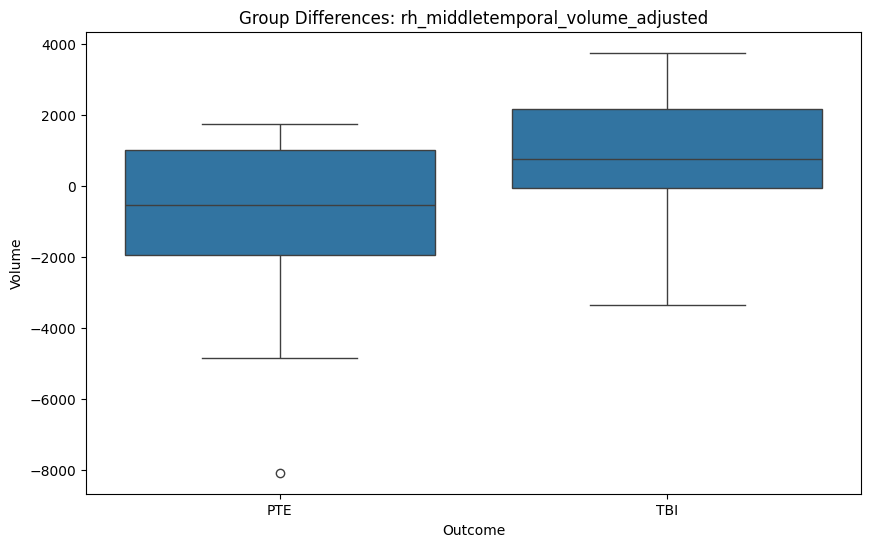

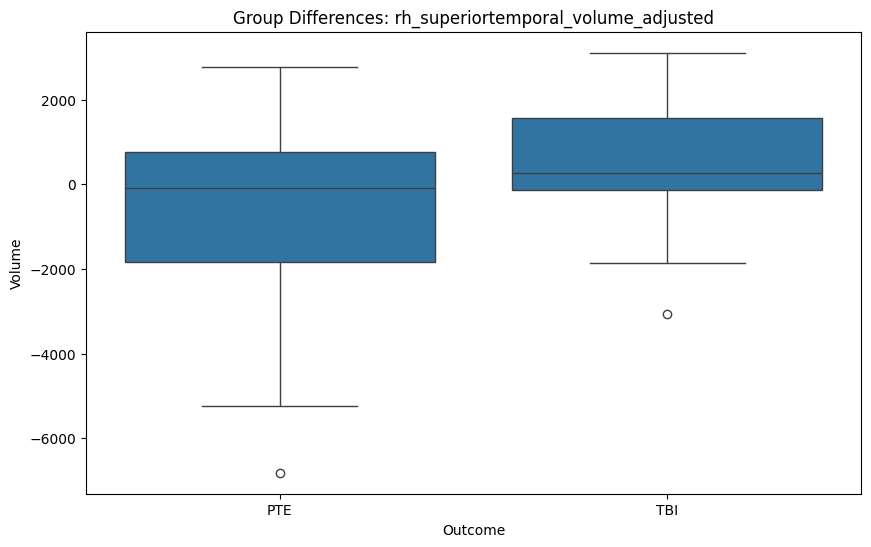

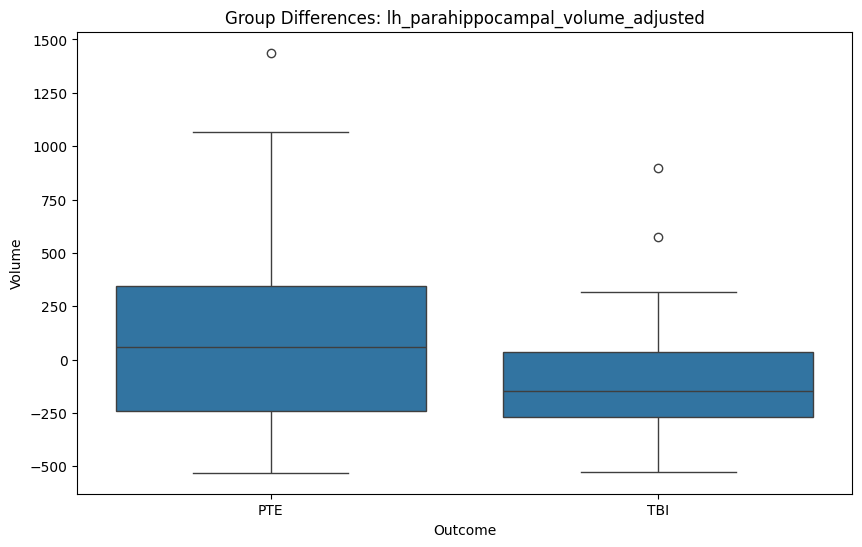

In [13]:
# Key regions to visualize
regions = [
    'rh_middletemporal_volume_adjusted',
    'rh_superiortemporal_volume_adjusted',
    'lh_parahippocampal_volume_adjusted'
]

# Create boxplots
for region in regions:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='outcome', y=region, data=volume_adj)
    plt.title(f'Group Differences: {region}')
    plt.xlabel('Outcome')
    plt.ylabel('Volume')
    plt.show()

## Summary and Conclusions

Key findings:
1. Model performances for different feature sets
2. Best class weights for each model
3. Most discriminative brain regions
4. Recommendations for future analysis